In [0]:
from google.colab import files                   # since data was taken from kaggle, hence kaggle token used
import os
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [0]:
!ls -lha kaggle.json
!pip install statsmodels==0.11.0rc1
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download --force -d sudalairajkumar/covid19-in-india

-rw-r--r-- 1 root root 67 May 12 12:10 kaggle.json
  0% 0.00/191k [00:00<?, ?B/s]
100% 191k/191k [00:00<00:00, 28.8MB/s]


In [0]:
!unzip covid19-in-india.zip                            # covid19-in-india.zip has been pushed seperately in the repo

Archive:  covid19-in-india.zip
replace AgeGroupDetails.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: AgeGroupDetails.csv     
  inflating: HospitalBedsIndia.csv   
  inflating: ICMRTestingDetails.csv  
  inflating: ICMRTestingLabs.csv     
  inflating: IndividualDetails.csv   
  inflating: StatewiseTestingDetails.csv  
  inflating: covid_19_india.csv      
  inflating: population_india_census2011.csv  


In [0]:
import pandas as pd
import numpy as np
import datetime
import warnings
from datetime import timedelta
warnings.filterwarnings('ignore')
raw_data = pd.read_csv('covid_19_india.csv')

In [0]:
x = np.array(raw_data['Time'])
u = np.unique(x)
print(u)                                                                      # replacing the AM-PM timestyle with 24 hour timestyle
raw_data['Time'][raw_data['Time'] == '10:00 AM'] = '10:00:00' 
raw_data['Time'][raw_data['Time'] == '10:00 AM'] = '10:00:00' 
raw_data['Time'][raw_data['Time'] == '8:00 AM'] = '08:00:00'
raw_data['Time'][raw_data['Time'] == '5:00 PM'] = '17:00:00'                                     # replacing the AM-PM timestyle with 24 hour timestyle
raw_data['Time'][raw_data['Time'] == '6:00 PM'] = '18:00:00'
raw_data['Time'][raw_data['Time'] == '7:30 PM'] = '19:30:00'
raw_data['Time'][raw_data['Time'] == '8:30 PM'] = '20:30:00'
raw_data['Time'][raw_data['Time'] == '9:30 PM'] = '21:30:00'     
print(raw_data['Time'])

['10:00 AM' '5:00 PM' '6:00 PM' '7:30 PM' '8:00 AM' '8:30 PM' '9:30 PM']
0       18:00:00
1       18:00:00
2       18:00:00
3       18:00:00
4       18:00:00
          ...   
1864    08:00:00
1865    08:00:00
1866    08:00:00
1867    08:00:00
1868    08:00:00
Name: Time, Length: 1869, dtype: object


In [0]:
raw_data['Date'] = raw_data['Date'] + '20'
raw_data['Datetime'] = raw_data['Date'] + ' ' + raw_data['Time']
for i in range(len(raw_data['Datetime'])):
  raw_data['Datetime'][i] = datetime.datetime.strptime(raw_data['Datetime'][i],'%d/%m/%Y %H:%M:%S')  
print(raw_data['Datetime'])                                                                              # converting all the dates in string to datetime data type

0       2020-01-30 18:00:00
1       2020-01-31 18:00:00
2       2020-02-01 18:00:00
3       2020-02-02 18:00:00
4       2020-02-03 18:00:00
               ...         
1864    2020-05-12 08:00:00
1865    2020-05-12 08:00:00
1866    2020-05-12 08:00:00
1867    2020-05-12 08:00:00
1868    2020-05-12 08:00:00
Name: Datetime, Length: 1869, dtype: object


In [0]:
statewise = raw_data.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max()
statewise['Active'] = statewise['Confirmed'] - statewise['Deaths'] - statewise['Cured']
print(statewise)                                                                # displaying statewise statistics as they stand for better understanding

                             Confirmed  Deaths  Cured  Active
State/UnionTerritory                                         
Andaman and Nicobar Islands         33       0     33       0
Andhra Pradesh                    2018      45    975     998
Arunachal Pradesh                    1       0      1       0
Assam                               65       2     34      29
Bihar                              747       6    377     364
Chandigarh                         174       2     24     148
Chhattisgarh                        59       0     53       6
Dadar Nagar Haveli                   1       0      0       1
Delhi                             7233      73   2129    5031
Goa                                  7       0      7       0
Gujarat                           8541     513   2780    5248
Haryana                            730      11    337     382
Himachal Pradesh                    59       2     39      18
Jammu and Kashmir                  879      10    427     442
Jharkhan

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot

In [0]:
def predcountry(raw_data,days_in_advance):
  raw_data['Datetime'] = raw_data['Date'] + ' ' + raw_data['Time']
  for i in range(len(raw_data['Datetime'])):
    raw_data['Datetime'][i] = datetime.datetime.strptime(raw_data['Datetime'][i],'%d/%m/%Y %H:%M:%S')  
  #print(raw_data['Datetime'])     
  country_data = raw_data.groupby("Datetime")[["Confirmed","Cured","Deaths"]].sum().reset_index()
  country_data['Active'] = country_data['Confirmed'] - country_data['Cured'] - country_data['Deaths']            
  #print(country_data)                             
  country_data['ds'] = country_data['Datetime']
  country_data['y'] = country_data['Confirmed'] 
  testing = country_data.loc[:,('Confirmed','Datetime')]
  model2 = ARIMA(testing['Confirmed'],order = [5,1,0])
  model2 = model2.fit()
  forecast = model2.forecast(steps = 30)
  pred = list(forecast[0].astype(int))
  y = country_data['Confirmed']
  y = y.append(pd.Series(pred))
  y = y.reset_index(drop = True)
  #print(y)
  x = pd.Series(pd.date_range(raw_data['Date'][0],periods=len(y)))
  #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
   #print(x)
  plt.plot(x,y,linestyle = 'solid')
  plt.show()
  return pred[days_in_advance].astype(int),x,y

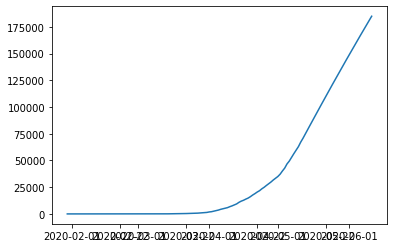

Expected confirmed cases by 2020-05-22 are 82639


In [0]:
+mmmmmmmmmmmmmmval,x,y = predcountry(raw_data,2)
print("Expected confirmed cases by " + str((datetime.datetime.today().date()+timedelta(days=10)))+" are " + str(val))

In [0]:
def pred_state(raw_data,state,days_in_advance):
  delh = raw_data[raw_data['State/UnionTerritory'] == state].reset_index()
  #print(delh)
  tdata = delh.loc[:,('Datetime','Confirmed')]
  model1 = ARIMA(tdata['Confirmed'],order = [5,1,0])
  model1 = model1.fit(trend = 'c')
  forec = model1.forecast(steps = 30)
  pred = list(forec[0])
  y = delh['Confirmed']
  y = y.append(pd.Series(pred))
  y = y.reset_index(drop = True)
  #print(y)
  x = pd.Series(pd.date_range(raw_data['Date'][0],periods=len(y)))
  return pred[days_in_advance].astype(int),x,y

Expected Confirmed cases in Delhi by 2020-05-17 is 9143


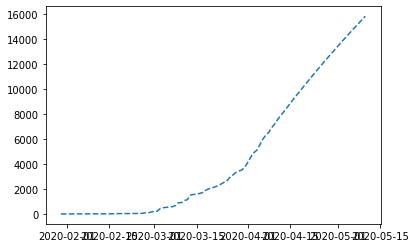

In [0]:
state = 'Delhi'
days = 5
val2,x1,y1 = pred_state(raw_data,state,days)
print("Expected Confirmed cases in " + state + " by " + str((datetime.datetime.today().date()+timedelta(days=days)))+" is "+str(val2))
plt.plot(x1,y1,linestyle = 'dashed')